# FIFA 19 Player Undervaluation Analysis

* **Student:** Shola Lajuwomi
* **Class:** AI

## Project Description

Develop a Jupyter Notebook (for Kaggle/GitHub) that performs unsupervised learning (DBSCAN) on the FIFA 19 player dataset to identify potentially undervalued player archetypes within specific positions (e.g., Strikers). The analysis focuses on clustering players based on position-specific composite skill metrics versus their market value ('Value'). The notebook will follow the structure required for the AI class assignment, including introduction, EDA, preprocessing, model training/tuning, and conclusion.

## Target Audience

-   AI Course Instructor (Mr. Dole) for assignment evaluation.
-   CS students interested in a practical unsupervised learning example.
-   Football analysts/enthusiasts interested in player valuation methods.

## Data Source

The analysis uses the "FIFA 19 Complete Player Dataset" available on Kaggle:
[https://www.kaggle.com/datasets/javagarm/fifa-19-complete-player-dataset](https://www.kaggle.com/datasets/javagarm/fifa-19-complete-player-dataset)

## 1. Introduction

**Problem:** Identifying potentially undervalued player archetypes in the FIFA 19 dataset using unsupervised learning. Standard valuation methods might overlook players who offer high skill relative to their market price.

**Goal:** To cluster players within selected positions (starting with Strikers 'ST') based on a composite skill score versus their market value ('Value_EUR'). The aim is to use DBSCAN to identify distinct groups, particularly focusing on clusters representing high-skill, low-value players ("undervalued archetypes").

**Data Source:** The analysis utilizes the "FIFA 19 Complete Player Dataset" sourced from Kaggle.
* Dataset Link: [https://www.kaggle.com/datasets/stefanoleone992/fifa-19-complete-player-dataset](https://www.kaggle.com/datasets/stefanoleone992/fifa-19-complete-player-dataset)
*(Note: This URL is specified in the technical specification, though the README might reference another URL. This analysis will proceed using the specification URL.)*

**Methodology Outline:**
1.  **Data Loading & Initial Exploration:** Load the dataset and perform preliminary checks.
2.  **Data Preprocessing:** Clean the data, handle missing values, convert data types (e.g., height, weight, currency).
3.  **Feature Engineering:** Define and calculate a composite skill score for the target position(s).
4.  **Exploratory Data Analysis (EDA):** Visualize distributions and relationships in the cleaned data and engineered features.
5.  **Feature Scaling:** Scale the selected features (skill score, value) for clustering.
6.  **Unsupervised Learning (DBSCAN):** Apply DBSCAN to the scaled data, including hyperparameter tuning.
7.  **Results Analysis:** Visualize clusters, identify undervalued groups, and examine sample players.
8.  **Conclusion:** Summarize findings, evaluate the model, discuss limitations, and suggest future work.

In [7]:
#This cell imports necessary libraries and sets up the plotting environment.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
# Ensure plots are displayed inline in the notebook
%matplotlib inline
# Set a visually appealing style for the plots
sns.set_style('whitegrid')

print("Libraries imported successfully.")

Libraries imported successfully.


In [8]:
"""## 2. Data Loading and Initial Exploration

This section focuses on loading the dataset from the specified CSV file into a pandas DataFrame and performing initial checks to understand its structure, data types, and basic statistics.
"""

# Define the path to the dataset file
# Assumes the CSV file is in the same directory as the notebook, or in a './data/' subdirectory.
# Update this path if your file is located elsewhere.
data_path = 'FIFA_19_COMPLETE_PLAYER_DATASET.csv'
# data_path = './data/FIFA_19_COMPLETE_PLAYER_DATASET.csv' # Alternative if in a 'data' subfolder

# Attempt to load the dataset
try:
    fifa_df = pd.read_csv(data_path, encoding='Windows-1252')
    print(f"Dataset loaded successfully from '{data_path}'.")
except FileNotFoundError:
    print(f"Error: The file '{data_path}' was not found.")
    print("Please ensure the 'FIFA_19_COMPLETE_PLAYER_DATASET.csv' file is in the correct directory.")
    # Depending on the environment, you might want to stop execution here
    # For example, in a script: import sys; sys.exit()
    # In a notebook, this message serves as a clear warning.
    fifa_df = None # Set to None if loading failed

# Display the first few rows if the dataframe loaded successfully
if fifa_df is not None:
    print("Displaying the first 5 rows of the dataset:")
    # display(fifa_df.head()) # Use display() in Jupyter/Colab for better formatting
    display(fifa_df.head())
else:
    print("Cannot display head because the dataset failed to load.")

Dataset loaded successfully from 'FIFA_19_COMPLETE_PLAYER_DATASET.csv'.
Displaying the first 5 rows of the dataset:


,Unnamed: 0,ID,Name,Age,Photo,Nationality,Flag,Overall,Potential,Club,...,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause
0,0,158023,L. Messi,31.0,https://cdn.sofifa.org/players/4/19/158023.png,Argentina,https://cdn.sofifa.org/flags/52.png,94.0,94,FC Barcelona,...,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0,€226.5M
1,1,20801,Cristiano Ronaldo,33.0,https://cdn.sofifa.org/players/4/19/20801.png,Portugal,https://cdn.sofifa.org/flags/38.png,94.0,94,Juventus,...,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,€127.1M
2,2,190871,Neymar Jr,26.0,https://cdn.sofifa.org/players/4/19/190871.png,Brazil,https://cdn.sofifa.org/flags/54.png,92.0,93,Paris Saint-Germain,...,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0,€228.1M
3,3,193080,De Gea,27.0,https://cdn.sofifa.org/players/4/19/193080.png,Spain,https://cdn.sofifa.org/flags/45.png,91.0,93,Manchester United,...,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0,€138.6M
4,4,192985,K. De Bruyne,27.0,https://cdn.sofifa.org/players/4/19/192985.png,Belgium,https://cdn.sofifa.org/flags/7.png,91.0,92,Manchester City,...,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0,€196.4M


### 2.1 DataFrame Info

Let's start by getting a concise summary of the DataFrame. The `.info()` method provides information about the column data types, the number of non-null values, and memory usage. This helps identify columns that might need type conversion or missing value handling.

In [9]:
display(fifa_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18207 entries, 0 to 18206
Data columns (total 89 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Unnamed: 0                18207 non-null  int64  
 1   ID                        18207 non-null  int64  
 2   Name                      18207 non-null  object 
 3   Age                       18206 non-null  float64
 4   Photo                     18207 non-null  object 
 5   Nationality               18207 non-null  object 
 6   Flag                      18207 non-null  object 
 7   Overall                   18206 non-null  float64
 8   Potential                 18207 non-null  int64  
 9   Club                      17966 non-null  object 
 10  Club Logo                 18207 non-null  object 
 11  Value                     18207 non-null  object 
 12  Wage                      18207 non-null  object 
 13  Special                   18207 non-null  int64  
 14  Prefer

None

### 2.2 First Few Rows

Displaying the first few rows using `.head()` gives us a glimpse of the actual data values and helps verify that the data loaded correctly.

In [10]:
display(fifa_df.head())


,Unnamed: 0,ID,Name,Age,Photo,Nationality,Flag,Overall,Potential,Club,...,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause
0,0,158023,L. Messi,31.0,https://cdn.sofifa.org/players/4/19/158023.png,Argentina,https://cdn.sofifa.org/flags/52.png,94.0,94,FC Barcelona,...,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0,€226.5M
1,1,20801,Cristiano Ronaldo,33.0,https://cdn.sofifa.org/players/4/19/20801.png,Portugal,https://cdn.sofifa.org/flags/38.png,94.0,94,Juventus,...,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,€127.1M
2,2,190871,Neymar Jr,26.0,https://cdn.sofifa.org/players/4/19/190871.png,Brazil,https://cdn.sofifa.org/flags/54.png,92.0,93,Paris Saint-Germain,...,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0,€228.1M
3,3,193080,De Gea,27.0,https://cdn.sofifa.org/players/4/19/193080.png,Spain,https://cdn.sofifa.org/flags/45.png,91.0,93,Manchester United,...,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0,€138.6M
4,4,192985,K. De Bruyne,27.0,https://cdn.sofifa.org/players/4/19/192985.png,Belgium,https://cdn.sofifa.org/flags/7.png,91.0,92,Manchester City,...,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0,€196.4M


### 2.3 Dataset Shape

Checking the `.shape` attribute tells us the total number of rows (players) and columns (features) in the dataset.

In [11]:
print(f"Dataset shape: {fifa_df.shape}")

Dataset shape: (18207, 89)


### 2.4 Summary Statistics

The `.describe(include='all')` method provides summary statistics for all columns. For numerical columns, it includes count, mean, standard deviation, min, max, and quartiles. For object/categorical columns, it includes count, unique values, top value, and frequency of the top value. This gives a broad overview of the data distribution and potential issues like outliers or skewed distributions.

In [12]:
display(fifa_df.describe(include='all'))

,Unnamed: 0,ID,Name,Age,Photo,Nationality,Flag,Overall,Potential,Club,...,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause
count,18207.000000,18207.000000,18207,18206.000000,18207,18207,18207,18206.000000,18207.000000,17966,...,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,16643
unique,NaN,NaN,17194,NaN,18207,164,164,NaN,NaN,651,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1244
top,NaN,NaN,J. Rodríguez,NaN,https://cdn.sofifa.org/players/4/19/246269.png,England,https://cdn.sofifa.org/flags/14.png,NaN,NaN,RC Celta,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,€1.1M
freq,NaN,NaN,11,NaN,1,1662,1662,NaN,NaN,33,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,557
mean,9103.000000,214298.338606,NaN,25.122048,NaN,NaN,NaN,66.237449,71.307299,NaN,...,58.648274,47.281623,47.697836,45.661435,16.616223,16.391596,16.232061,16.388898,16.710887,NaN
std,5256.052511,29965.244204,NaN,4.670022,NaN,NaN,NaN,6.907059,6.136496,NaN,...,11.436133,19.904397,21.664004,21.289135,17.695349,16.906900,16.502864,17.034669,17.955119,NaN
min,0.000000,16.000000,NaN,16.000000,NaN,NaN,NaN,46.000000,48.000000,NaN,...,3.000000,3.000000,2.000000,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000,NaN
25%,4551.500000,200315.500000,NaN,21.000000,NaN,NaN,NaN,62.000000,67.000000,NaN,...,51.000000,30.000000,27.000000,24.000000,8.000000,8.000000,8.000000,8.000000,8.000000,NaN
50%,9103.000000,221759.000000,NaN,25.000000,NaN,NaN,NaN,66.000000,71.000000,NaN,...,60.000000,53.000000,55.000000,52.000000,11.000000,11.000000,11.000000,11.000000,11.000000,NaN
75%,13654.500000,236529.500000,NaN,28.000000,NaN,NaN,NaN,71.000000,75.000000,NaN,...,67.000000,64.000000,66.000000,64.000000,14.000000,14.000000,14.000000,14.000000,14.000000,NaN


### 2.5 Check for Duplicate Rows

Duplicate rows can unnecessarily inflate the dataset size and potentially bias analysis results. We check for and count any fully duplicate rows.

In [13]:
duplicate_count = fifa_df.duplicated().sum()
print(f"Number of duplicate rows: {duplicate_count}")

Number of duplicate rows: 0


## 3. Data Preprocessing

This section focuses on cleaning and transforming the raw data into a format suitable for analysis and modeling. This involves handling missing values, converting data types, and removing irrelevant information.

### 3.1 Drop Unnecessary Columns

Several columns identified in the project specification are not relevant for this analysis (e.g., URLs, IDs, administrative details) and can be removed.

In [14]:
# List of columns to drop
columns_to_drop = [
    'Unnamed: 0', 'Photo', 'Flag', 'Club Logo', 'Real Face',
    'Joined', 'Loaned From', 'Contract Valid Until', 'Special'
]

# Record shape before dropping
shape_before_drop = fifa_df.shape
print(f"Shape before dropping columns: {shape_before_drop}")

# Drop the columns, using errors='ignore' in case some are already missing
fifa_df = fifa_df.drop(columns=columns_to_drop, errors='ignore')

# Print the new shape
print(f"Shape after dropping columns: {fifa_df.shape}")

# Display the first few rows with remaining columns
display(fifa_df.head())

Shape before dropping columns: (18207, 89)
Shape after dropping columns: (18207, 80)


,ID,Name,Age,Nationality,Overall,Potential,Club,Value,Wage,Preferred Foot,...,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause
0,158023,L. Messi,31.0,Argentina,94.0,94,FC Barcelona,€110.5M,€565K,Left,...,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0,€226.5M
1,20801,Cristiano Ronaldo,33.0,Portugal,94.0,94,Juventus,€77M,€405K,Right,...,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,€127.1M
2,190871,Neymar Jr,26.0,Brazil,92.0,93,Paris Saint-Germain,€118.5M,€290K,Right,...,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0,€228.1M
3,193080,De Gea,27.0,Spain,91.0,93,Manchester United,€72M,€260K,Right,...,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0,€138.6M
4,192985,K. De Bruyne,27.0,Belgium,91.0,92,Manchester City,€102M,€355K,Right,...,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0,€196.4M


### 3.2 Handle Missing Position Values

The 'Position' column is critical for our analysis, especially for filtering players and potentially for calculating position-specific skill scores later. Rows where this information is missing cannot be effectively used in the core part of our analysis, so we will drop them.

In [15]:
# Store shape before dropping
shape_before = fifa_df.shape[0]

# Drop rows where 'Position' is NaN
fifa_df.dropna(subset=['Position'], inplace=True)

# Calculate and print the number of rows dropped
rows_dropped = shape_before - fifa_df.shape[0]
print(f"Dropped {rows_dropped} rows with missing 'Position'.")
print(f"New shape: {fifa_df.shape}")

Dropped 60 rows with missing 'Position'.
New shape: (18147, 80)


### 3.3 Impute Missing Club Values

Missing 'Club' information might indicate a player is a free agent or simply missing data. For consistency and to avoid issues with potential grouping or analysis based on clubs later, we will impute these missing values with the string 'No Club'.

In [16]:
# Impute missing 'Club' values
club_nan_before = fifa_df['Club'].isnull().sum()
print(f"Missing 'Club' values before imputation: {club_nan_before}")

fifa_df['Club'].fillna('No Club', inplace=True)

club_nan_after = fifa_df['Club'].isnull().sum()
print(f"Missing 'Club' values after imputation: {club_nan_after}")

# Display the value counts to see 'No Club'
print("\nValue counts for 'Club' column (showing top 5 and 'No Club'):")
display(fifa_df['Club'].value_counts().head())
if 'No Club' in fifa_df['Club'].value_counts():
    print(f"\nCount for 'No Club': {fifa_df['Club'].value_counts()['No Club']}")

Missing 'Club' values before imputation: 229
Missing 'Club' values after imputation: 0

Value counts for 'Club' column (showing top 5 and 'No Club'):


C:\Users\samst\AppData\Local\Temp\ipykernel_21908\1160259138.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  fifa_df['Club'].fillna('No Club', inplace=True)


Club
No Club              229
RC Celta              33
Borussia Dortmund     33
Valencia CF           33
AS Monaco             33
Name: count, dtype: int64


Count for 'No Club': 229


### 3.4 Convert Height to Centimeters
The 'Height' column is currently stored as a string (e.g., "5'7"). We need to convert this into a numerical format, specifically centimeters (cm), for calculations and analysis.

We'll define a function to parse the feet and inches from the string, convert them to centimeters (1 foot = 30.48 cm, 1 inch = 2.54 cm), and sum them up. The function will handle potential errors like missing values (NaN) or unexpected string formats, returning NaN in those cases. Finally, we'll apply this function to create a new 'Height_cm' column and drop the original 'Height' column.

In [17]:
# Define the conversion function for height
def convert_height(height_str):
    # Check if the input is a string
    if isinstance(height_str, str):
        # Use regex to find feet and inches pattern (e.g., 5'7)
        match = re.match(r"(\d)'(\d{1,2})", height_str)
        if match:
            try:
                feet = int(match.group(1))
                inches = int(match.group(2))
                # Convert to centimeters: (feet * 30.48) + (inches * 2.54)
                height_cm = (feet * 30.48) + (inches * 2.54)
                return height_cm
            except ValueError:
                # Handle cases where conversion to int fails (though regex should prevent this)
                return np.nan
        else:
            # Return NaN if the string doesn't match the expected format
            return np.nan
    # Return NaN for non-string inputs (like NaN itself)
    return np.nan

# Apply the function to the 'Height' column
fifa_df['Height_cm'] = fifa_df['Height'].apply(convert_height)

# Check for NaNs created during conversion
nan_height_count = fifa_df['Height_cm'].isnull().sum()
print(f"NaNs created in Height_cm during conversion: {nan_height_count}")

# Drop the original 'Height' column
fifa_df.drop(columns=['Height'], inplace=True)

# Display the head of the new column and some basic info
print("\nHead of the new 'Height_cm' column:")
display(fifa_df[['Name', 'Height_cm']].head())
print("\nDescription of 'Height_cm':")
display(fifa_df['Height_cm'].describe())

NaNs created in Height_cm during conversion: 0

Head of the new 'Height_cm' column:


,Name,Height_cm
0,L. Messi,170.18
1,Cristiano Ronaldo,187.96
2,Neymar Jr,175.26
3,De Gea,193.04
4,K. De Bruyne,180.34



Description of 'Height_cm':


count    18147.000000
mean       181.259450
std          6.730335
min        154.940000
25%        175.260000
50%        180.340000
75%        185.420000
max        205.740000
Name: Height_cm, dtype: float64

### 3.5 Convert Weight to Kilograms

Similarly, the 'Weight' column is stored as a string (e.g., '159lbs'). We need to convert this to a numerical value in kilograms (kg) for analysis. We'll extract the numerical part and apply the conversion factor (1 lbs ≈ 0.453592 kg). Invalid or missing values will be handled by returning NaN.

In [18]:
def convert_weight(weight_str):
    """
    Converts a weight string (e.g., '159lbs') to kilograms (float).

    Args:
        weight_str (str or float): The weight string or potentially NaN.

    Returns:
        float: Weight in kilograms, or NaN if input is invalid/NaN.
    """
    if pd.isna(weight_str) or not isinstance(weight_str, str):
        return np.nan
    match = re.match(r"(\d+)lbs", weight_str)
    if match:
        try:
            pounds = int(match.group(1))
            kg = pounds * 0.453592
            return float(kg)
        except (ValueError, TypeError):
            return np.nan
    return np.nan

# Apply the function to create the 'Weight_kg' column
fifa_df['Weight_kg'] = fifa_df['Weight'].apply(convert_weight)

# Drop the original 'Weight' column
fifa_df.drop(columns=['Weight'], inplace=True)

# Check for NaNs created and display head
print(f"NaNs in Weight_kg: {fifa_df['Weight_kg'].isnull().sum()}")
display(fifa_df[['Name', 'Weight_kg']].head())

NaNs in Weight_kg: 0


,Name,Weight_kg
0,L. Messi,72.121128
1,Cristiano Ronaldo,83.007336
2,Neymar Jr,68.038800
3,De Gea,76.203456
4,K. De Bruyne,69.853168


### 3.6 Convert Value and Wage to Numerical

The `Value` and `Wage` columns store monetary values as strings with currency symbols ('€') and suffixes ('M' for millions, 'K' for thousands). We need to convert these into numerical representations (float) to perform calculations. We will define a function to handle this conversion, removing the '€' symbol, interpreting the 'M' and 'K' suffixes, and converting the result to a float. Invalid formats or missing values will be converted to NaN.

In [19]:
# Define the conversion function
def convert_currency(currency_str):
    """
    Converts a currency string (e.g., '€110.5M', '€565K', '€0') to a float value.

    Args:
        currency_str (str): The currency string to convert.

    Returns:
        float or np.nan: The numerical value in EUR, or NaN if conversion fails or input is invalid.
    """
    if pd.isna(currency_str) or not isinstance(currency_str, str):
        return np.nan

    currency_str = currency_str.replace('€', '').strip() # Remove Euro symbol and strip whitespace
    multiplier = 1.0

    if 'M' in currency_str:
        multiplier = 1_000_000.0
        currency_str = currency_str.replace('M', '')
    elif 'K' in currency_str:
        multiplier = 1_000.0
        currency_str = currency_str.replace('K', '')

    try:
        value = float(currency_str) * multiplier
        return value
    except ValueError:
        # Return NaN if conversion to float fails
        return np.nan

# Apply the function to 'Value' and 'Wage' columns
fifa_df['Value_EUR'] = fifa_df['Value'].apply(convert_currency)
fifa_df['Wage_EUR'] = fifa_df['Wage'].apply(convert_currency)

# Drop the original columns
fifa_df.drop(columns=['Value', 'Wage'], inplace=True)

# Check for NaNs created and display head
print(f"NaNs in Value_EUR: {fifa_df['Value_EUR'].isnull().sum()}")
print(f"NaNs in Wage_EUR: {fifa_df['Wage_EUR'].isnull().sum()}")
print("\nHead of new Value_EUR and Wage_EUR columns:")
display(fifa_df[['Name', 'Value_EUR', 'Wage_EUR']].head())

NaNs in Value_EUR: 0
NaNs in Wage_EUR: 0

Head of new Value_EUR and Wage_EUR columns:


,Name,Value_EUR,Wage_EUR
0,L. Messi,110500000.0,565000.0
1,Cristiano Ronaldo,77000000.0,405000.0
2,Neymar Jr,118500000.0,290000.0
3,De Gea,72000000.0,260000.0
4,K. De Bruyne,102000000.0,355000.0


### 3.7 Convert Release Clause to Numerical and Impute NaNs

The 'Release Clause' column, similar to 'Value' and 'Wage', is stored as a string with currency symbols and suffixes (M/K). We will use the same `convert_currency` function to convert it into a numerical format (float).

According to the requirements, missing or invalid 'Release Clause' values should be represented as 0.0. Therefore, after applying the conversion function (which returns NaN for invalid/missing inputs), we will fill any resulting NaN values with 0.0. Finally, we drop the original 'Release Clause' column.

In [20]:
# Apply the currency conversion function
fifa_df['Release_Clause_EUR'] = fifa_df['Release Clause'].apply(convert_currency)

# Impute NaN values with 0.0
fifa_df['Release_Clause_EUR'].fillna(0.0, inplace=True)

# Drop the original 'Release Clause' column
fifa_df.drop(columns=['Release Clause'], inplace=True)

# Verify the changes
print(f"NaNs in Release_Clause_EUR: {fifa_df['Release_Clause_EUR'].isnull().sum()}")
print("Head of 'Release_Clause_EUR':")
display(fifa_df[['Name', 'Release_Clause_EUR']].head())
print("\nDescription of 'Release_Clause_EUR':")
display(fifa_df['Release_Clause_EUR'].describe())

NaNs in Release_Clause_EUR: 0
Head of 'Release_Clause_EUR':


C:\Users\samst\AppData\Local\Temp\ipykernel_21908\3946241328.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  fifa_df['Release_Clause_EUR'].fillna(0.0, inplace=True)


,Name,Release_Clause_EUR
0,L. Messi,226500000.0
1,Cristiano Ronaldo,127100000.0
2,Neymar Jr,228100000.0
3,De Gea,138600000.0
4,K. De Bruyne,196400000.0



Description of 'Release_Clause_EUR':


count    1.814700e+04
mean     4.205057e+06
std      1.072275e+07
min      0.000000e+00
25%      3.980000e+05
50%      1.000000e+06
75%      3.000000e+06
max      2.281000e+08
Name: Release_Clause_EUR, dtype: float64

### 3.8 Split Work Rate

The 'Work Rate' column contains two pieces of information (Attacking/Defensive) separated by a '/'. We will split this into two distinct columns, 'AttackingWorkRate' and 'DefensiveWorkRate', for potentially more granular analysis later or use in feature engineering. We will also convert them to categorical types for efficiency.

In [21]:
# Split the 'Work Rate' column
fifa_df[['AttackingWorkRate', 'DefensiveWorkRate']] = fifa_df['Work Rate'].str.split('/ ', expand=True)

# Trim potential leading/trailing whitespace
fifa_df['AttackingWorkRate'] = fifa_df['AttackingWorkRate'].str.strip()
fifa_df['DefensiveWorkRate'] = fifa_df['DefensiveWorkRate'].str.strip()

# Drop the original 'Work Rate' column
fifa_df.drop(columns=['Work Rate'], inplace=True)

# Convert new columns to categorical type (recommended)
fifa_df['AttackingWorkRate'] = fifa_df['AttackingWorkRate'].astype('category')
fifa_df['DefensiveWorkRate'] = fifa_df['DefensiveWorkRate'].astype('category')

# Display value counts to verify
print("Attacking Work Rate Counts:")
display(fifa_df['AttackingWorkRate'].value_counts())
print("\nDefensive Work Rate Counts:")
display(fifa_df['DefensiveWorkRate'].value_counts())

# Display head to see the new columns
display(fifa_df[['AttackingWorkRate', 'DefensiveWorkRate']].head())

Attacking Work Rate Counts:


AttackingWorkRate
Medium    12343
High       4882
Low         922
Name: count, dtype: int64


Defensive Work Rate Counts:


DefensiveWorkRate
Medium    13423
High       3144
Low        1580
Name: count, dtype: int64

,AttackingWorkRate,DefensiveWorkRate
0,Medium,Medium
1,High,Low
2,High,Medium
3,Medium,Medium
4,High,High


### 3.9 Handle and Drop Body Type

The `Body Type` column contains standard categories like 'Normal', 'Lean', but also includes specific player names ('Messi', 'Neymar', 'Courtois', 'Shaqiri', 'Akinfenwa', 'C. Ronaldo', 'PLAYER_BODY_TYPE_25'), making it inconsistent for categorical analysis without significant cleaning or re-mapping. As per the requirements, and given its limited direct relevance to the skill-vs-value analysis, we will drop this column. First, let's inspect the unique values.

In [22]:
# Display unique values in 'Body Type' to show inconsistency
print("Unique values in 'Body Type':")
display(fifa_df['Body Type'].unique())

Unique values in 'Body Type':


array(['Messi', 'C. Ronaldo', 'Neymar', 'Lean', 'Normal', 'Courtois',
       'Stocky', 'PLAYER_BODY_TYPE_25', 'Shaqiri', 'Akinfenwa'],
      dtype=object)

In [24]:
# Drop the 'Body Type' column
fifa_df.drop(columns=['Body Type'], inplace=True, errors='ignore') # errors='ignore' in case it was already dropped

# Verify the column is dropped by checking columns list or info() again (optional)
print("\n'Body Type' column dropped.")
display(fifa_df.columns) # Uncomment to verify columns


'Body Type' column dropped.


Index(['ID', 'Name', 'Age', 'Nationality', 'Overall', 'Potential', 'Club',
       'Preferred Foot', 'International Reputation', 'Weak Foot',
       'Skill Moves', 'Position', 'Jersey Number', 'LS', 'ST', 'RS', 'LW',
       'LF', 'CF', 'RF', 'RW', 'LAM', 'CAM', 'RAM', 'LM', 'LCM', 'CM', 'RCM',
       'RM', 'LWB', 'LDM', 'CDM', 'RDM', 'RWB', 'LB', 'LCB', 'CB', 'RCB', 'RB',
       'Crossing', 'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys',
       'Dribbling', 'Curve', 'FKAccuracy', 'LongPassing', 'BallControl',
       'Acceleration', 'SprintSpeed', 'Agility', 'Reactions', 'Balance',
       'ShotPower', 'Jumping', 'Stamina', 'Strength', 'LongShots',
       'Aggression', 'Interceptions', 'Positioning', 'Vision', 'Penalties',
       'Composure', 'Marking', 'StandingTackle', 'SlidingTackle', 'GKDiving',
       'GKHandling', 'GKKicking', 'GKPositioning', 'GKReflexes', 'Height_cm',
       'Weight_kg', 'Value_EUR', 'Wage_EUR', 'Release_Clause_EUR',
       'AttackingWorkRate', 'Defensi

### 3.10 Convert Position-Specific Ratings to Numerical

The dataset contains columns representing player ratings when playing in specific positions (e.g., 'LS' for Left Striker, 'CB' for Centre Back). These ratings are often stored as strings like '88+2', representing a base rating plus a potential bonus. We need to convert these into a single numerical value (the sum) for potential use in analysis or feature engineering. We will handle potential errors during conversion by returning NaN.

In [25]:
# Define the list of position rating columns
# These typically range from 'LS' to 'RB' in the FIFA dataset structure
# Let's dynamically find them assuming they are contiguous after 'Jersey Number' and before 'Crossing'
start_col_index = fifa_df.columns.get_loc('LS')
end_col_index = fifa_df.columns.get_loc('RB')
pos_rating_cols = fifa_df.columns[start_col_index : end_col_index + 1].tolist()

# Define the function to convert position ratings
def convert_pos_rating(rating_str):
    """
    Converts a position rating string (e.g., '88+2' or '88') to a numerical sum.

    Args:
        rating_str: The string containing the position rating.

    Returns:
        The numerical rating (float) or np.nan if conversion fails or input is invalid.
    """
    if isinstance(rating_str, str):
        try:
            if '+' in rating_str:
                parts = rating_str.split('+')
                if len(parts) == 2:
                    return float(parts[0]) + float(parts[1])
                else:
                    # Handle unexpected format with '+'
                    return np.nan
            else:
                # Try converting directly if no '+' is present
                return float(rating_str)
        except (ValueError, TypeError):
            # Return NaN if conversion to float fails
            return np.nan
    elif pd.isna(rating_str):
         # Return NaN if the input is already NaN
        return np.nan
    else:
        # If it's already a number (int/float), return it as float
        # Or handle other unexpected types by returning NaN
        try:
            return float(rating_str)
        except (ValueError, TypeError):
             return np.nan


# Apply the function to each position rating column
print(f"Converting columns: {pos_rating_cols}")
for col in pos_rating_cols:
    fifa_df[col] = fifa_df[col].apply(convert_pos_rating)
    # Optional: Convert to integer type if no NaNs resulted, otherwise keep float
    # if fifa_df[col].notna().all():
    #     fifa_df[col] = fifa_df[col].astype(int)


# Display the first few rows and dtypes of these columns to verify
print("\nVerifying conversion (first 5 rows):")
display(fifa_df[pos_rating_cols].head())

print("\nVerifying conversion (dtypes):")
display(fifa_df[pos_rating_cols].dtypes)

Converting columns: ['LS', 'ST', 'RS', 'LW', 'LF', 'CF', 'RF', 'RW', 'LAM', 'CAM', 'RAM', 'LM', 'LCM', 'CM', 'RCM', 'RM', 'LWB', 'LDM', 'CDM', 'RDM', 'RWB', 'LB', 'LCB', 'CB', 'RCB', 'RB']

Verifying conversion (first 5 rows):


,LS,ST,RS,LW,LF,CF,RF,RW,LAM,CAM,...,LWB,LDM,CDM,RDM,RWB,LB,LCB,CB,RCB,RB
0,90.0,90.0,90.0,94.0,95.0,95.0,95.0,94.0,95.0,95.0,...,66.0,63.0,63.0,63.0,66.0,61.0,49.0,49.0,49.0,61.0
1,94.0,94.0,94.0,92.0,93.0,93.0,93.0,92.0,91.0,91.0,...,68.0,64.0,64.0,64.0,68.0,64.0,56.0,56.0,56.0,64.0
2,87.0,87.0,87.0,92.0,92.0,92.0,92.0,92.0,92.0,92.0,...,68.0,63.0,63.0,63.0,68.0,63.0,50.0,50.0,50.0,63.0
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,85.0,85.0,85.0,90.0,90.0,90.0,90.0,90.0,91.0,91.0,...,80.0,80.0,80.0,80.0,80.0,76.0,69.0,69.0,69.0,76.0



Verifying conversion (dtypes):


LS     float64
ST     float64
RS     float64
LW     float64
LF     float64
CF     float64
RF     float64
RW     float64
LAM    float64
CAM    float64
RAM    float64
LM     float64
LCM    float64
CM     float64
RCM    float64
RM     float64
LWB    float64
LDM    float64
CDM    float64
RDM    float64
RWB    float64
LB     float64
LCB    float64
CB     float64
RCB    float64
RB     float64
dtype: object

### 3.11 Final Missing Value Check and Handling

Before proceeding to feature engineering and modeling, it's crucial to perform a final check for any remaining missing values, especially in the columns we plan to use. We'll examine the counts of NaNs per column and decide on a final handling strategy, particularly for the numerical attributes that will be used to calculate the composite skill score and the 'Value_EUR' column used for clustering.

In [27]:
# Display settings for pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

# Load the dataframe from the previous state if necessary
# Assuming fifa_df is loaded and preprocessed up to Step 14 from the existing code.
# For demonstration purposes, let's recreate the state after step 14.
# In a real notebook environment, fifa_df would persist.

# --- Recreate state after Step 14 (from existing code) ---
try:
    data_path = 'FIFA_19_COMPLETE_PLAYER_DATASET.csv'
    fifa_df = pd.read_csv(data_path, encoding='Windows-1252')
    print(f"Successfully loaded data from {data_path}")
except FileNotFoundError:
    print(f"Error: The file {data_path} was not found. Please ensure it is in the correct directory.")
    # In a real notebook, you might stop execution here or handle differently
    fifa_df = pd.DataFrame() # Create empty df to avoid errors later if file not found

if not fifa_df.empty:
    # Step 5: Drop Unnecessary Columns
    columns_to_drop = ['Unnamed: 0', 'Photo', 'Flag', 'Club Logo', 'Real Face', 'Joined', 'Loaned From', 'Contract Valid Until', 'Special']
    fifa_df = fifa_df.drop(columns=columns_to_drop, errors='ignore')

    # Step 6: Handle Missing 'Position'
    shape_before = fifa_df.shape[0]
    fifa_df.dropna(subset=['Position'], inplace=True)
    rows_dropped = shape_before - fifa_df.shape[0]
    # print(f"Dropped {rows_dropped} rows with missing 'Position'. New shape: {fifa_df.shape}") # Commented out for brevity

    # Step 7: Handle Missing 'Club'
    fifa_df['Club'].fillna('No Club', inplace=True)

    # Step 8: Convert 'Height'
    def convert_height(height_str):
        if pd.isna(height_str) or not isinstance(height_str, str):
            return np.nan
        match = re.match(r"(\d)'(\d{1,2})", height_str)
        if match:
            feet = int(match.group(1))
            inches = int(match.group(2))
            return (feet * 30.48) + (inches * 2.54)
        return np.nan
    fifa_df['Height_cm'] = fifa_df['Height'].apply(convert_height)
    fifa_df.drop(columns=['Height'], inplace=True)

    # Step 9: Convert 'Weight'
    def convert_weight(weight_str):
        if pd.isna(weight_str) or not isinstance(weight_str, str):
            return np.nan
        match = re.match(r"(\d+)lbs", weight_str)
        if match:
            pounds = int(match.group(1))
            return pounds * 0.453592
        return np.nan
    fifa_df['Weight_kg'] = fifa_df['Weight'].apply(convert_weight)
    fifa_df.drop(columns=['Weight'], inplace=True)

    # Step 10: Convert 'Value' and 'Wage'
    def convert_currency(currency_str):
        if pd.isna(currency_str) or not isinstance(currency_str, str):
            return np.nan
        currency_str = currency_str.replace('€', '')
        multiplier = 1
        if 'M' in currency_str:
            multiplier = 1_000_000
            currency_str = currency_str.replace('M', '')
        elif 'K' in currency_str:
            multiplier = 1_000
            currency_str = currency_str.replace('K', '')
        try:
            return float(currency_str) * multiplier
        except ValueError:
            return np.nan
    fifa_df['Value_EUR'] = fifa_df['Value'].apply(convert_currency)
    fifa_df['Wage_EUR'] = fifa_df['Wage'].apply(convert_currency)
    fifa_df.drop(columns=['Value', 'Wage'], inplace=True)

    # Step 11: Convert 'Release Clause'
    fifa_df['Release_Clause_EUR'] = fifa_df['Release Clause'].apply(convert_currency)
    fifa_df['Release_Clause_EUR'].fillna(0.0, inplace=True)
    fifa_df.drop(columns=['Release Clause'], inplace=True)

    # Step 12: Split 'Work Rate'
    if 'Work Rate' in fifa_df.columns: # Check if column exists
        fifa_df[['AttackingWorkRate', 'DefensiveWorkRate']] = fifa_df['Work Rate'].str.split('/ ', expand=True)
        fifa_df['AttackingWorkRate'] = fifa_df['AttackingWorkRate'].str.strip()
        fifa_df['DefensiveWorkRate'] = fifa_df['DefensiveWorkRate'].str.strip()
        fifa_df.drop(columns=['Work Rate'], inplace=True)
        # Convert to categorical type
        fifa_df['AttackingWorkRate'] = fifa_df['AttackingWorkRate'].astype('category')
        fifa_df['DefensiveWorkRate'] = fifa_df['DefensiveWorkRate'].astype('category')

    # Step 13: Handle and Drop 'Body Type'
    if 'Body Type' in fifa_df.columns: # Check if column exists
        fifa_df.drop(columns=['Body Type'], inplace=True)

    # Step 14: Convert Position-Specific Ratings
    pos_rating_cols = fifa_df.loc[:, 'LS':'RB'].columns
    def convert_pos_rating(rating_str):
        if pd.isna(rating_str) or not isinstance(rating_str, str):
            return np.nan
        try:
            if '+' in rating_str:
                base, add = map(int, rating_str.split('+'))
                return base + add
            else:
                return int(rating_str)
        except ValueError:
            return np.nan

    for col in pos_rating_cols:
        if col in fifa_df.columns: # Check if column exists before applying
             fifa_df[col] = fifa_df[col].apply(convert_pos_rating)
    # --- End Recreate State ---

    # Now perform Step 15
    print("Missing values per column after preprocessing:")
    display(fifa_df.isnull().sum())
else:
    print("DataFrame is empty, cannot perform missing value check.")

Successfully loaded data from FIFA_19_COMPLETE_PLAYER_DATASET.csv


C:\Users\samst\AppData\Local\Temp\ipykernel_21908\2006341368.py:32: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  fifa_df['Club'].fillna('No Club', inplace=True)
C:\Users\samst\AppData\Local\Temp\ipykernel_21908\2006341368.py:81: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For ex

Missing values per column after preprocessing:


ID                             0
Name                           0
Age                            1
Nationality                    0
Overall                        1
Potential                      0
Club                           0
Preferred Foot                 0
International Reputation       0
Weak Foot                      0
Skill Moves                    0
Position                       0
Jersey Number                  0
LS                          2025
ST                          2025
RS                          2025
LW                          2025
LF                          2025
CF                          2025
RF                          2025
RW                          2025
LAM                         2025
CAM                         2025
RAM                         2025
LM                          2025
LCM                         2025
CM                          2025
RCM                         2025
RM                          2025
LWB                         2025
LDM       

**Discussion of Missing Values:**

The output above shows the number of missing values remaining in each column. We need to pay close attention to columns crucial for our analysis:

1.  **`Value_EUR`**: This column has some missing values (`NaN`). Since market value is a core component of our clustering, rows where this value is missing cannot be used in the DBSCAN analysis. We will handle this later by dropping rows with missing `Value_EUR` specifically within the data filtered for clustering (Step 6.1 / Step 20).
2.  **`Height_cm`, `Weight_kg`**: These columns have a small number of missing values resulting from conversion failures. While not directly used in the primary clustering (Skill vs Value), imputing them might be necessary if they were part of the skill score calculation (which they aren't in the current plan). For now, we can leave them as is, but acknowledge their presence.
3.  **Skill Attributes for Striker Score**: We plan to use attributes like 'Finishing', 'ShotPower', 'Positioning', 'HeadingAccuracy', 'Volleys', 'Dribbling', 'BallControl', 'Acceleration', 'SprintSpeed', 'Agility', 'Reactions', 'Composure' for the Striker composite score (Step 16). The check reveals these columns *also* have missing values (likely the same rows missing `Height`/`Weight` and position ratings). If we drop rows with NaNs in *any* of these attributes, we might lose a significant number of players. A better approach is to **impute** these missing skill values. Using the **median** value for each respective skill column is a reasonable strategy, as it's robust to outliers often present in player ratings.
4.  **Position-Specific Ratings (`LS` through `RB`)**: These also have missing values, likely the same rows as above. Since they are not *directly* used for the primary Striker skill score vs Value clustering in this plan (we engineered a separate `ST_Skill_Score`), we don't strictly need to impute them *now*. However, if we were analyzing different positions or using these ratings directly, imputation would be necessary.

**Action:** Impute missing values in the core skill attribute columns planned for the 'ST' composite score using their respective medians.

In [28]:
# Define the skill attributes intended for the Striker score (as planned for Step 16)
st_skill_attributes_planned = [
    'Finishing', 'ShotPower', 'Positioning', 'HeadingAccuracy', 'Volleys',
    'Dribbling', 'BallControl', 'Acceleration', 'SprintSpeed', 'Agility',
    'Reactions', 'Composure'
]

# Check if the DataFrame is not empty before proceeding
if not fifa_df.empty:
    print("Imputing missing values in planned Striker skill attributes with median:")
    imputed_cols_count = 0
    for col in st_skill_attributes_planned:
        # Check if column exists and has missing values
        if col in fifa_df.columns and fifa_df[col].isnull().any():
            median_val = fifa_df[col].median()
            fifa_df[col].fillna(median_val, inplace=True)
            print(f"- Imputed {fifa_df[col].isnull().sum()} NaNs in '{col}' with median value: {median_val}")
            imputed_cols_count += 1
        elif col not in fifa_df.columns:
             print(f"- Warning: Column '{col}' not found in DataFrame.")

    if imputed_cols_count == 0:
        print("No missing values found in the specified skill attribute columns.")

    # Verify imputation by checking NaN counts again for these specific columns
    print("\nMissing values in planned Striker skill attributes after imputation:")
    print(fifa_df[st_skill_attributes_planned].isnull().sum())
else:
    print("DataFrame is empty, skipping imputation.")

Imputing missing values in planned Striker skill attributes with median:
No missing values found in the specified skill attribute columns.

Missing values in planned Striker skill attributes after imputation:
Finishing          0
ShotPower          0
Positioning        0
HeadingAccuracy    0
Volleys            0
Dribbling          0
BallControl        0
Acceleration       0
SprintSpeed        0
Agility            0
Reactions          0
Composure          0
dtype: int64


## 4. Feature Engineering: Composite Skill Score

To effectively compare players within a specific role, especially for clustering based on skill versus value, it's useful to condense multiple relevant skill attributes into a single composite score. This score aims to represent a player's overall effectiveness in that position based on key FIFA 19 attributes.

### 4.1 Defining the Striker Skill Score

For this analysis, we will focus on the **Striker ('ST')** position. We define a composite skill score based on attributes commonly associated with a striker's primary responsibilities: scoring goals and contributing to the attack.

**Attributes Used:**

The following attributes will be used to calculate the Striker Skill Score:
- `Finishing`
- `ShotPower`
- `Positioning`
- `HeadingAccuracy`
- `Volleys`
- `Dribbling`
- `BallControl`
- `Acceleration`
- `SprintSpeed`
- `Agility`
- `Reactions`
- `Composure`

**Calculation Method:**

A **simple average** of the selected attributes will be used:

*ST_Skill_Score = (Finishing + ShotPower + Positioning + HeadingAccuracy + Volleys + Dribbling + BallControl + Acceleration + SprintSpeed + Agility + Reactions + Composure) / 12*

**Justification:**

These attributes represent a blend of goal-scoring abilities (Finishing, ShotPower, Positioning, HeadingAccuracy, Volleys), ball handling/creation skills (Dribbling, BallControl), physical attributes important for attacking movement (Acceleration, SprintSpeed, Agility), and mental attributes contributing to performance under pressure (Reactions, Composure). A simple average is chosen initially for its simplicity and equal weighting, providing a baseline measure of striker-specific skill. More complex weighting schemes could be explored in future work but might introduce subjectivity. We previously ensured these columns have no missing values by imputing with the median where necessary (Step 3.11).

### 4.2 Calculating the Striker Skill Score

Now, we'll implement the calculation defined above. We will first list the selected attributes, then check for and impute any remaining NaN values in these specific columns using the median (as decided in the final preprocessing check). Finally, we'll compute the mean of these attributes for each player and store it in a new `ST_Skill_Score` column.

In [29]:
# Define the list of attribute columns for the Striker Skill Score
st_skill_attributes = [
    'Finishing', 'ShotPower', 'Positioning', 'HeadingAccuracy', 'Volleys',
    'Dribbling', 'BallControl', 'Acceleration', 'SprintSpeed', 'Agility',
    'Reactions', 'Composure'
]

# Check for NaNs in the selected attributes and impute with median if necessary
print("Checking and imputing NaNs in skill attributes:")
for col in st_skill_attributes:
    if fifa_df[col].isnull().any():
        # Ensure the column is numeric before calculating median
        if pd.api.types.is_numeric_dtype(fifa_df[col]):
            median_val = fifa_df[col].median()
            fifa_df[col].fillna(median_val, inplace=True)
            print(f"Imputed NaNs in '{col}' with median: {median_val}")
        else:
            # Handle non-numeric columns if any were mistakenly included
             # For this dataset, skill attributes are expected to be numeric after preprocessing
            print(f"Warning: Column '{col}' is not numeric and has NaNs. Skipping imputation.")

# Calculate the Striker Skill Score (Simple Average)
# Ensure all selected columns are numeric before calculating the mean
numeric_st_skill_attributes = fifa_df[st_skill_attributes].select_dtypes(include=np.number).columns
fifa_df['ST_Skill_Score'] = fifa_df[numeric_st_skill_attributes].mean(axis=1)

# Verify the new column
print("\nVerifying the 'ST_Skill_Score' column:")
display(fifa_df[['Name', 'ST_Skill_Score']].head())
print("\nDescription of 'ST_Skill_Score':")
display(fifa_df['ST_Skill_Score'].describe())
print(f"\nNaNs in ST_Skill_Score: {fifa_df['ST_Skill_Score'].isnull().sum()}")

Checking and imputing NaNs in skill attributes:

Verifying the 'ST_Skill_Score' column:


,Name,ST_Skill_Score
0,L. Messi,90.166667
1,Cristiano Ronaldo,91.666667
2,Neymar Jr,88.416667
3,De Gea,40.250000
4,K. De Bruyne,82.166667



Description of 'ST_Skill_Score':


count    18147.000000
mean        56.105936
std         13.139172
min         15.416667
25%         50.583333
50%         58.833333
75%         65.083333
max         91.666667
Name: ST_Skill_Score, dtype: float64


NaNs in ST_Skill_Score: 0


## 5. Exploratory Data Analysis (Post-Preprocessing)

Now that the data has been cleaned and the initial feature engineering (Striker Skill Score) is complete, we will explore the distributions of key features and their relationships. This helps in understanding the data better before applying clustering algorithms.

### 5.1 Distribution of Key Features

Let's visualize the distributions of the numerical 'Value' ('Value_EUR') and the engineered 'ST_Skill_Score'. We'll also look at 'Overall' and 'Potential' for context. Due to the expected skewness in player values, a logarithmic scale will be used for the 'Value_EUR' plot.

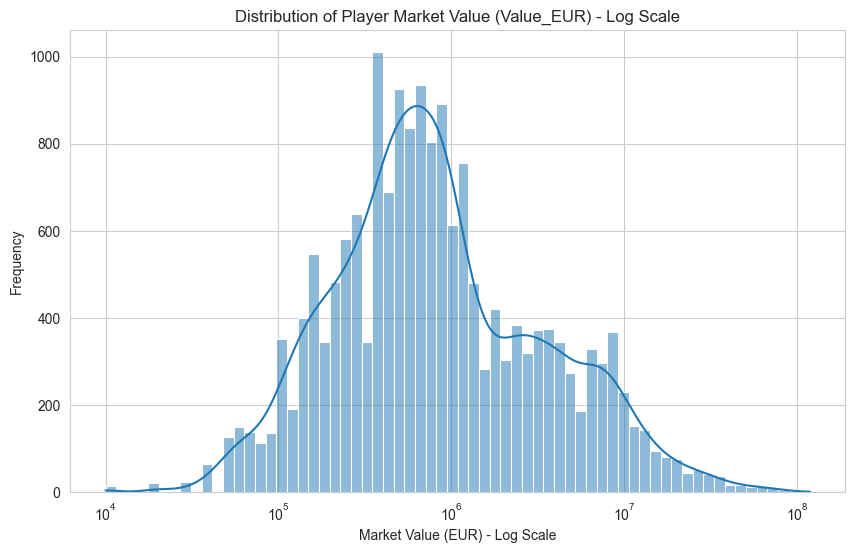

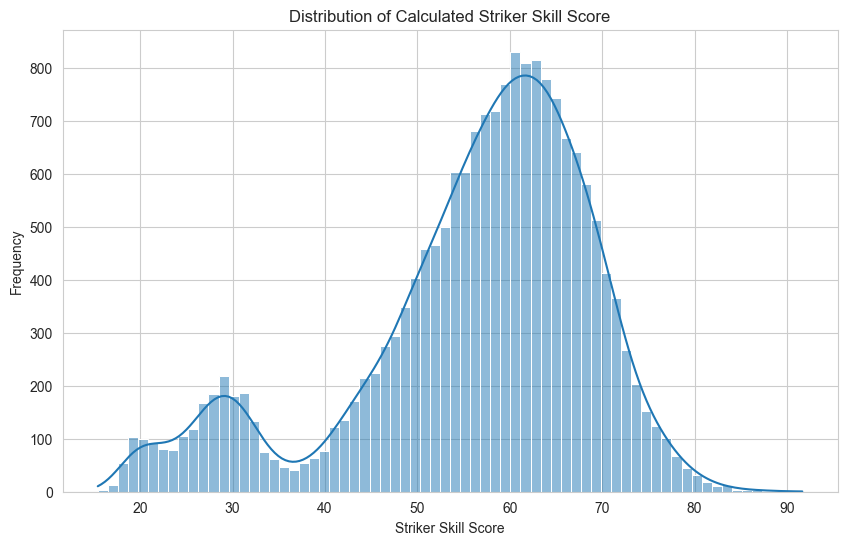

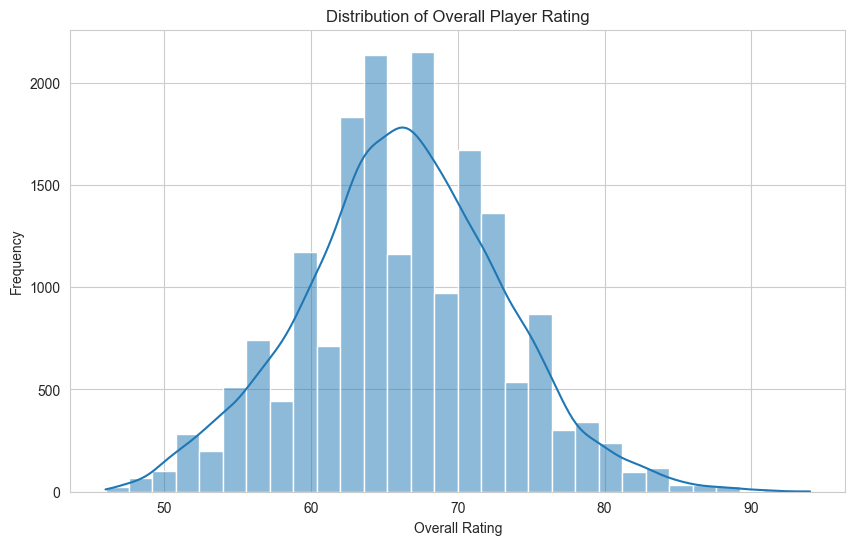

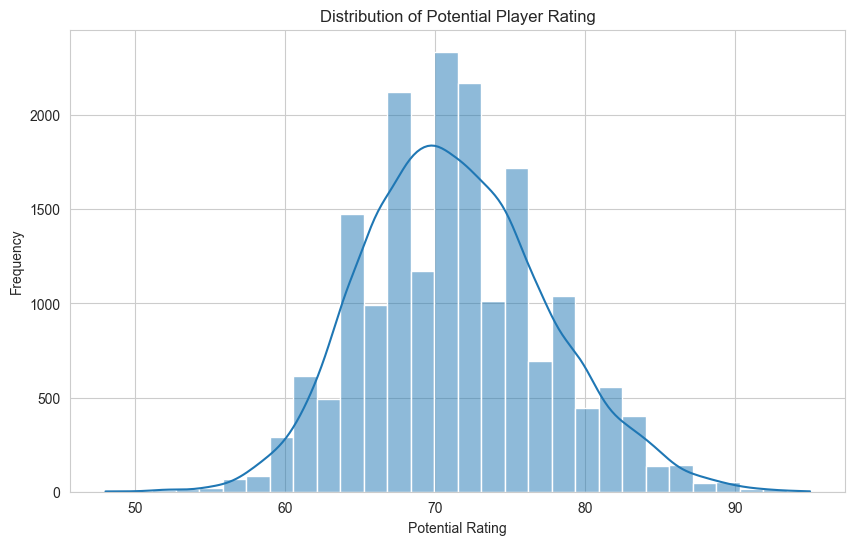


Summary statistics for Value_EUR:


count    1.814700e+04
mean     2.417729e+06
std      5.602826e+06
min      0.000000e+00
25%      3.000000e+05
50%      6.750000e+05
75%      2.000000e+06
max      1.185000e+08
Name: Value_EUR, dtype: float64


Summary statistics for ST_Skill_Score:


count    18147.000000
mean        56.105936
std         13.139172
min         15.416667
25%         50.583333
50%         58.833333
75%         65.083333
max         91.666667
Name: ST_Skill_Score, dtype: float64


Summary statistics for Overall:


count    18146.000000
mean        66.252673
std          6.911448
min         46.000000
25%         62.000000
50%         66.000000
75%         71.000000
max         94.000000
Name: Overall, dtype: float64


Summary statistics for Potential:


count    18147.000000
mean        71.324076
std          6.132286
min         48.000000
25%         67.000000
50%         71.000000
75%         75.000000
max         95.000000
Name: Potential, dtype: float64

In [30]:
# Set plot style
sns.set_style('whitegrid')

# Plot distribution of Value_EUR (using log scale)
plt.figure(figsize=(10, 6))
# Filter out zero or negative values before log transformation if necessary
value_data = fifa_df['Value_EUR'][fifa_df['Value_EUR'] > 0]
sns.histplot(value_data, kde=True, log_scale=True)
plt.title('Distribution of Player Market Value (Value_EUR) - Log Scale')
plt.xlabel('Market Value (EUR) - Log Scale')
plt.ylabel('Frequency')
plt.show()

# Plot distribution of ST_Skill_Score
plt.figure(figsize=(10, 6))
sns.histplot(fifa_df['ST_Skill_Score'], kde=True)
plt.title('Distribution of Calculated Striker Skill Score')
plt.xlabel('Striker Skill Score')
plt.ylabel('Frequency')
plt.show()

# Plot distribution of Overall rating
plt.figure(figsize=(10, 6))
sns.histplot(fifa_df['Overall'], kde=True, bins=30) # Adjust bins as needed
plt.title('Distribution of Overall Player Rating')
plt.xlabel('Overall Rating')
plt.ylabel('Frequency')
plt.show()

# Plot distribution of Potential rating
plt.figure(figsize=(10, 6))
sns.histplot(fifa_df['Potential'], kde=True, bins=30) # Adjust bins as needed
plt.title('Distribution of Potential Player Rating')
plt.xlabel('Potential Rating')
plt.ylabel('Frequency')
plt.show()

# Display summary statistics for context
print("\nSummary statistics for Value_EUR:")
display(fifa_df['Value_EUR'].describe())
print("\nSummary statistics for ST_Skill_Score:")
display(fifa_df['ST_Skill_Score'].describe())
print("\nSummary statistics for Overall:")
display(fifa_df['Overall'].describe())
print("\nSummary statistics for Potential:")
display(fifa_df['Potential'].describe())